<a id="index"></a>
# A modular processing pipeline for spiking sorting from axona raw data

The notebook largely follows the spiketutorial notebook from the Sep. 2020 developer workshop: https://github.com/SpikeInterface/spiketutorials/blob/master/NWB_Developer_Breakout_Session_Sep2020/SpikeInterface_Tutorial.ipynb

In this notebook we will cover the basics of using SpikeInterface for extracellular analysis and spike sorting comparison for axona raw, axona unit and intan data. We will be using `spikeinterface` from the [SpikeInterface](https://github.com/SpikeInterface) github organization. 

`spikeinterface` wraps 5 subpackages: `spikeextractors`, `spikesorters`, `spiketoolkit`, `spikecomparison`, and `spikewidgets`.

We will show how to
1. [Install dependencies](#install_dependencies)
2. [load data with spikeextractors](#load_data)
3. [Cache data](#cache)
5. [Spike sorting](#spike_sorting)
6. [Postprocess the signals](#postprocessing)
7. [Curate the spike sorting output](#spike_curation) using 1) quality metrics (automatic), 2) [Phy](https://github.com/cortex-lab/phy) (manual), and 3) consensus-based curation
8. [Export results to NWB](#export_nwb)
9. [Export results to TINT](#export_tint)


## Spikesorters docker

[`spikesorters_docker`](https://github.com/catalystneuro/spikesorters_docker/) is a test repo for trying to use dockerized environments for spike sorters within spikeinterface, using the [`hither`](https://github.com/flatironinstitute/hither) module. If this works, it would alleviate a headaches from installing different spikesorters coming from dependency issues or lacking Matlab licenses. 

In [3]:
!which python

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/bin/python


# Import packages

In [ ]:
# For trying in docker container
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams.update({'font.size':20})

import spikeextractors as se
import spiketoolkit as st
import spikesorters as ss

print(sys.version, sys.platform, sys.executable)

In [1]:
# General data handling and visualization
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams.update({'font.size':20})

# SpikeInterface
import spikeextractors as se
import spikewidgets as sw
import spiketoolkit as st
import spikesorters as ss
import spikesorters_docker as ssd
import spikecomparison as sc

print(sys.version, sys.platform, sys.executable)

17:51:19 [I] klustakwik KlustaKwik2 version git-a1d2eaac-dirty


3.8.5 (default, Jan 27 2021, 15:41:15) 
[GCC 9.3.0] linux /mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/bin/python3


<a id='load_data'></a>
# Load data
[back to index](#index)

Set path and base filename and create an `AxonaRecordingExtractor` instance. The `AxonaRecordingExtractor` will process .bin data together with a .set file. It is sufficient to pass the base filename (without ending), assuming that both files are in the same directory.

In [2]:
dir_name = r'/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw'
base_filename = 'axona_raw_5s'
filename = os.path.join(dir_name, base_filename)
print(filename)

/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw/axona_raw_5s


/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
r_cache = se.load_extractor_from_pickle(os.path.join(dir_name, 'cached_data_preproc.pkl'))

Versions are not the same. This might lead to errors. Use  spikeextractors version 0.9.5


In [4]:
print(f'Cached channels: {r_cache.get_channel_ids()}')
print(f'Cached channels ids: {r_cache.get_channel_ids()}')
print(f'Channel groups after caching: {r_cache.get_channel_groups()}')
print('Duration of recording in seconds: {}'.format(r_cache.get_num_frames() / r_cache.get_sampling_frequency()))

Cached channels: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Cached channels ids: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Channel groups after caching: [1 1 1 1 2 2 2 2 3 3 3 3]
Duration of recording in seconds: 2.0


**IMPORTANT**: the same caching/dumping mechanisms are available also for all `SortingExtractor` objects.

<a id='spike_sorting'></a>
# Spike sorting
[back to index](#index)

From https://github.com/catalystneuro/spikesorters_docker/blob/main/spikesorters_docker/sorters_containerized.py

In [14]:
from pathlib import Path
import hither2 as hither
import time
import numpy as np
import spikesorters as ss
import spikeextractors as se
from spikesorters_docker.default_docker_images import default_docker_images

In [15]:
def run_sorter(sorter_name, recording, output_folder, delete_output_folder=False,
               grouping_property=None, parallel=False, verbose=False, raise_error=True, n_jobs=-1,
               joblib_backend='loky', use_docker=True, container=None,
               **params):
    output_folder = Path(output_folder)
    recording_json = output_folder / "recording_input.json"
    sorting_json = output_folder / "sorting_output.json"

    # dump recording
    recording.dump_to_json(output_folder / "recording_input.json")

    if use_docker:
        if container is None:
            assert sorter_name in default_docker_images, f"Default docker image for {sorter_name} not found"
            docker_image = default_docker_images[sorter_name]

        print(f"Running in docker image {docker_image}")
        # define hither function with container at run time
        @hither.function('run_sorter_docker_with_container', '0.1.0', image=docker_image)
        # @hither.container(docker_image)
        def run_sorter_docker_with_container(
                recording_json, sorter_name, **kwargs
        ):
            recording = se.load_extractor_from_json(recording_json)
            # run sorter
            t_start = time.time()
            sorting = ss.run_sorter(sorter_name, recording, **kwargs)
            t_stop = time.time()
            print(f'{sorter_name} run time {np.round(t_stop - t_start)}s')
            output_folder = Path(kwargs['output_folder'])
            sorting.dump_to_json(output_folder / 'sorting_output.json')

        sorting_job = run_sorter_docker_with_container.run(recording_json=recording_json, sorter_name=sorter_name,
                                                           output_folder=output_folder,
                                                           delete_output_folder=delete_output_folder,
                                                           grouping_property=grouping_property, parallel=parallel,
                                                           verbose=verbose, raise_error=raise_error, n_jobs=n_jobs,
                                                           joblib_backend=joblib_backend,
                                                           **params)
        sorting_job.wait()
        sorting = se.load_extractor_from_json(sorting_json)
    else:
        sorting = None
        print('Standard sorting is turned off, sorry!')

    return sorting

In [20]:
sorting_KL_all = run_sorter(
    sorter_name='klusta',
    recording=r_cache, 
    output_folder=os.path.join(dir_name, 'klusta'), 
    adjacency_radius=50, 
    verbose=True, 
    threshold_weak_std_factor=3,
    use_docker=True
)
print('Found', len(sorting_KL_all.get_unit_ids()), 'units')

Running in docker image docker://spikeinterface/klusta:0.1.0
HITHER JOBS: 1 pending; 0 queued; 1 running; 3 finished; 1 errored; 0 cache hits
Elapsed time for manage-pending-jobs: 7.563678979873657 sec
Found 8 units


In [22]:
sorting_HS = run_sorter(
    sorter_name='herdingspikes',
    recording=r_cache,
    output_folder=os.path.join(dir_name, 'herdingspikes'),
    verbose=True,
    use_docker=True
)
print('Found', len(sorting_HS.get_unit_ids()), 'units')

Running in docker image docker://spikeinterface/herdingspikes:0.1.0
HITHER JOBS: 1 pending; 0 queued; 1 running; 4 finished; 2 errored; 0 cache hits
Elapsed time for manage-pending-jobs: 2.240556001663208 sec


Exception: Error in run_sorter_docker_with_container (0.1.0): Spike sorting failed: 'DataFrame' object has no attribute 'cl'. You can inspect the runtime trace in the herdingspikes.log of the output folder.'

### Klusta

In [5]:
sorting_KL_all = ssd.run_klusta(
    r_cache, 
    output_folder=os.path.join(dir_name, 'klusta'), 
    adjacency_radius=50, 
    verbose=True, 
    threshold_weak_std_factor=3,
    use_docker=True
)
print('Found', len(sorting_KL_all.get_unit_ids()), 'units')

Running in docker image docker://spikeinterface/klusta:0.1.0


/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextractors/baseextractor.py:607: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif isinstance(v, (np.int, np.int32, np.int64)):
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextractors/baseextractor.py:609: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.


Elapsed time for manage-pending-jobs: 9.121309041976929 sec
HITHER JOBS: 0 pending; 0 queued; 0 running; 1 finished; 0 errored; 0 cache hits
Found 7 units


Since we have tetrodes and we know that they are physically apart, we would like to sort them separately as follows:

In [6]:
sorting_KL = ssd.run_klusta(
    r_cache, 
    adjacency_radius=50, 
    output_folder=os.path.join(dir_name, 'klusta_by_group'), 
    grouping_property='group', 
    parallel=True, 
    threshold_weak_std_factor=3,
    use_docker=True
)
print(f'Klusta found {len(sorting_KL.get_unit_ids())} units')

Running in docker image docker://spikeinterface/klusta:0.1.0
Elapsed time for manage-pending-jobs: 15.917546033859253 sec
HITHER JOBS: 0 pending; 0 queued; 0 running; 2 finished; 0 errored; 0 cache hits
Klusta found 10 units


In [7]:
#print(type(sorting_KL_all))
print(type(sorting_KL))
print(type(sorting_KL.sortings[0]))

<class 'spikeextractors.multisortingextractor.MultiSortingExtractor'>
<class 'spikeextractors.extractors.klustaextractors.klustaextractors.KlustaSortingExtractor'>


In [8]:
print(f'Klusta unit ids (no groups): {sorting_KL_all.get_unit_ids()}')
print(f'Klusta unit ids (with groups): {sorting_KL.get_unit_ids()}')

Klusta unit ids (no groups): [0, 2, 3, 4, 5, 6, 7]
Klusta unit ids (with groups): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [9]:
print(f'Spike train of a unit: {sorting_KL.get_unit_spike_train(1)}')

Spike train of a unit: [  263   667  1277  1349  1495  1754  2055  2262  2460  3167  3401  4438
  6008  6866  7624  7906  8207  8255  8393  9286  9388  9428  9471  9635
  9658  9691  9836  9900 10552 11569 12016 13055 13652 14937 15586 15627
 16612 16725 16880 17037 17332 17409 17452 17601 17711 18053 18221 18227
 18339 18368 18540 18884 18899 19076 19131 19465 19501 19589 19740 20227
 21693 22143 22279 22551 22822 22852 23119 23198 23311 23328 23384 23434
 23491 23507 23576 23614 23699 23745 23786 23806 23847 23857 23923 23944
 23982 24037 24067 24164 24270 24316 24913 24931 25062 25088 25656 25749
 25803 25816 25863 25900 26001 26078 26102 26115 26216 26258 26288 26330
 26384 26396 26425 26466 26499 26614 27394 27646 27912 27957 28378 29118
 29488 29619 29688 29794 30224 30359 30418 30479 30798 30858 30992 31538
 31711 31890 32089 32140 32302 32924 33469 33524 33647 33784 33881 33983
 34075 34111 34295 34321 34660 34670 34734 34818 35055 35381 35531 35626
 35674 35839 35912 35957 359

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextractors/extraction_tools.py:838: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextractors/extraction_tools.py:844: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprec

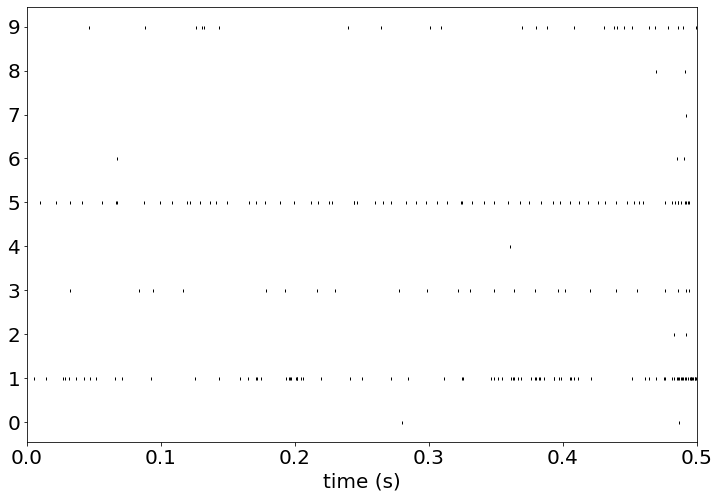

In [10]:
w_rs = sw.plot_rasters(sorting_KL, trange=[0,0.5])

### Mountainsort4

In [12]:
sorting_MS4 = ssd.run_mountainsort4(
    r_cache,
    os.path.join(dir_name, 'mountainsort4_group'),
    grouping_property='group',
    parallel=True,
    verbose=True,
    filter=False,
    use_docker=True
)
print(f'Mountainsort4 found {len(sorting_MS4.get_unit_ids())} units')

Running in docker image docker://spikeinterface/mountainsort4:0.1.0
HITHER JOBS: 1 pending; 0 queued; 0 running; 2 finished; 1 errored; 0 cache hits
Elapsed time for manage-pending-jobs: 236.3988220691681 sec


KeyboardInterrupt: 

In [ ]:
print(f'Spike train of a unit: {sorting_MS4.get_unit_spike_train(1)}')

### Herding spikes

In [11]:
sorting_HS = ssd.sorters_containerized.run_herdingspikes(
    r_cache,
    os.path.join(dir_name, 'herdingspikes_group'),
    filter=False,
    use_docker=True
)
print(f'Herding Spikes found {len(sorting_HS.get_unit_ids())} units')

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextractors/baseextractor.py:607: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif isi

Running in docker image docker://spikeinterface/herdingspikes:0.1.0
HITHER JOBS: 1 pending; 0 queued; 0 running; 2 finished; 0 errored; 0 cache hits
HITHER JOBS: 0 pending; 0 queued; 0 running; 2 finished; 1 errored; 0 cache hits


Exception: Error in run_sorter_docker_with_container (0.1.0): Spike sorting failed: 'DataFrame' object has no attribute 'cl'. You can inspect the runtime trace in the herdingspikes.log of the output folder.'

<a id='postprocessing'></a>
# 6. Postprocessing
[back to index](#index)

The `postprocessing` submodule of `spiketoolkit` allows us to extract information from the combination of the recording and sorting extractors. For example, we can extract waveforms, templates, maximum channels and pca scores. In addition, we can also compute waveform features that could be used for further processing, e.g. classyfing excitatory-inhibitory neurons.

Let's start by extracting waveforms.

In [9]:
waveforms = st.postprocessing.get_unit_waveforms(r_cache, sorting_KL, verbose=True)

Extracting waveforms in chunks: 100%|##########| 1/1 [00:00<00:00, 11.23it/s]

Number of chunks: 1 - Number of jobs: 1


In [10]:
waveforms[1].shape

(300, 12, 288)

Similarly, we can get templates, maximum channels, and pca scores. 
Whem these are computed, they are automatically stored in the `SortingExtractor` object, so that they don't need to be recomputed. 

Each waveform is associated with a specific spike, so they are saved as spike *features*:


You may have noticed that 300 waveforms were extracted from the spike train of the first unit. However, it has more spikes:

In [13]:
len(sorting_KL.get_unit_spike_train(1))

762

It can be convenient to only compute a subset of waveforms to speed up the calculation. The `waveform_idxs` property contains the spike indexes associated with the waveforms.

In [14]:
sorting_KL.get_shared_unit_spike_feature_names()

['waveforms', 'waveforms_idxs']

In [15]:
print(sorting_KL.get_unit_spike_features(1, 'waveforms_idxs'))

[  1   2   6   8  10  12  14  15  17  18  21  27  31  34  35  37  39  40
  45  48  49  50  52  55  62  64  66  68  71  75  76  77  78  79  85  89
  90  92  96  97 101 103 104 109 113 118 122 127 132 140 142 144 145 150
 155 156 157 159 161 162 165 170 172 173 175 178 181 187 188 190 193 194
 196 198 200 202 204 205 206 210 211 214 215 218 222 229 230 231 233 235
 236 239 240 241 242 243 245 247 249 250 251 252 253 255 258 261 263 266
 267 268 271 272 278 279 283 285 293 294 299 301 302 303 306 310 312 313
 315 316 317 318 319 327 331 333 334 337 338 344 346 350 351 352 354 355
 358 360 362 363 364 366 367 374 375 380 382 385 386 390 395 397 399 400
 401 402 403 404 406 407 409 412 413 415 417 418 422 424 425 427 432 434
 435 436 441 443 447 451 457 458 460 462 463 466 467 468 471 474 477 478
 479 485 489 494 495 499 500 501 503 504 506 516 518 520 521 522 523 524
 526 527 529 531 532 536 540 542 548 549 556 558 561 563 568 573 575 578
 579 582 584 586 588 592 593 601 603 605 613 615 61

Since waveforms are already computed, the next time we (or another function - e.g. `get_unit_templates()`) call it it will just return the stored waveforms.

In [16]:
waveforms = st.postprocessing.get_unit_waveforms(r_cache, sorting_KL, verbose=True)

Lighthing fast! 

If we want to recompute the waveforms, for example because we want to extract the waveforms divided by group, we can use the `recompute_info` argument (available for all `postprocessing`, `validation`, and `curation` functions):

Where are waveforms stored? We have seen above that each `Extractor` object has a tmp folder associated. Waveforms (and other features, e.g. pca scores) are stored in this folder as binary raw files:

In [17]:
tmp_folder = sorting_KL.get_tmp_folder()
print(tmp_folder)
print([(p.name) for p in tmp_folder.iterdir()])

/tmp/tmp6dmua9e0
['waveforms_0.raw', 'waveforms_1.raw', 'waveforms_2.raw', 'waveforms_3.raw', 'waveforms_4.raw', 'waveforms_5.raw', 'waveforms_6.raw', 'waveforms_7.raw', 'waveforms_8.raw']


In [18]:
waveforms_group = st.postprocessing.get_unit_waveforms(
    r_cache, sorting_KL, max_spikes_per_unit=None, 
    grouping_property='group', recompute_info=True,
    verbose=True
)

Number of chunks: 1 - Number of jobs: 1


Extracting waveforms in chunks: 100%|##########| 1/1 [00:00<00:00,  7.74it/s]


In [19]:
sorting_KL.get_shared_unit_property_names()

['group', 'quality', 'waveforms_channel_idxs']

In [20]:
for wf in waveforms_group:
    print(wf.shape)

(8, 4, 288)
(762, 4, 288)
(21, 4, 288)
(8, 4, 288)
(293, 4, 288)
(25, 4, 288)
(8, 4, 288)
(136, 4, 288)
(45, 4, 288)


We can use `spikewidgets` to quickly inspect the spike sorting output:

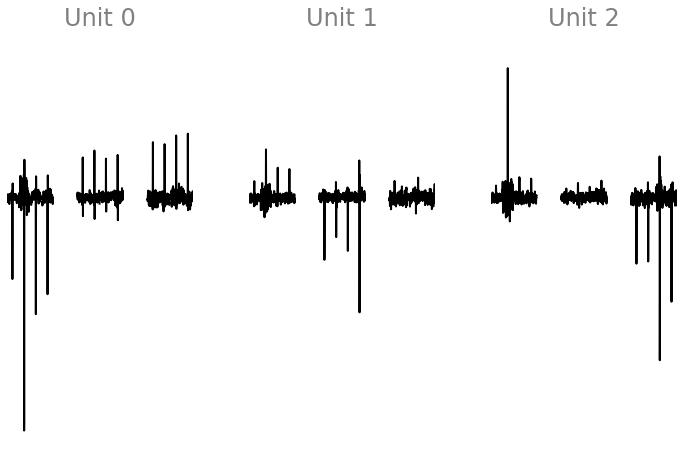

In [21]:
w_wf = sw.plot_unit_templates(sorting=sorting_IC, recording=r_cache)

/mnt/d/spikeinterface/hussaini-to-nwb/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:838: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:844: DeprecationWarning: `np.float` is

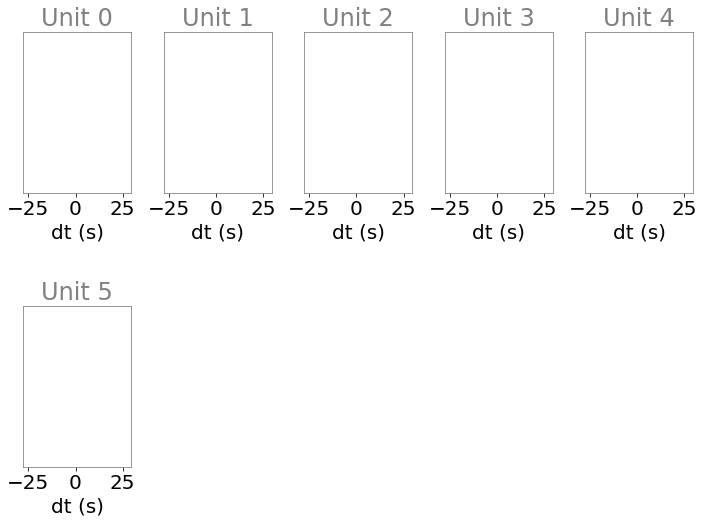

In [22]:
w_acc = sw.plot_autocorrelograms(sorting_IC, unit_ids=[0,1,2,3,4,5])

### Compute extracellular features

Extracellular features, such as peak to valley duration or full-width half maximum, are important to classify neurons into putative classes (excitatory - inhibitory). The `postprocessing` module of `spiketoolkit` allows one to compute several of these features:

In [23]:
st.postprocessing.get_template_features_list()

/mnt/d/spikeinterface/hussaini-to-nwb/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['peak_to_valley',
 'halfwidth',
 'peak_trough_ratio',
 'repolarization_slope',
 'recovery_slope']

In [24]:
features = st.postprocessing.compute_unit_template_features(
    r_cache, 
    sorting_KL, 
    as_dataframe=True, 
    upsampling_factor=10
)
display(features)

/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:838: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:844: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(end_frame, (float, np.float))

,peak_to_valley,halfwidth,peak_trough_ratio,repolarization_slope,recovery_slope
0,0.000554,0.001223,-0.797084,4.466142e+07,-1.922599e+07
1,0.000146,0.000108,-0.295551,2.110328e+08,-3.038246e+06
2,0.000338,0.000102,-0.647350,1.822814e+08,-2.105851e+07
3,0.000394,0.000119,-0.529854,9.223924e+07,-6.992583e+06
4,0.000133,0.000094,-0.572051,2.373724e+08,-8.350991e+06
5,0.000156,0.000108,-0.222512,1.410114e+08,-2.634128e+06
6,0.001829,0.000096,-0.306613,1.954598e+08,-5.546730e+06
7,0.000404,0.000108,-0.141827,2.041086e+08,-2.810326e+06
8,0.000148,0.000115,-0.404154,2.127449e+08,-1.043968e+07


For more information about these waveform features, we refer to this [documentation](https://github.com/AllenInstitute/ecephys_spike_sorting/tree/master/ecephys_spike_sorting/modules/mean_waveforms) from the Allen Institute.

### Validation

The `spiketoolkit` package also provides several functions to compute qualitity metrics about the spike sorting results through the `validation` module.

Let's see what metrics are available:

In [25]:
st.validation.get_quality_metrics_list()

/mnt/d/spikeinterface/hussaini-to-nwb/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['num_spikes',
 'firing_rate',
 'presence_ratio',
 'isi_violation',
 'amplitude_cutoff',
 'snr',
 'max_drift',
 'cumulative_drift',
 'silhouette_score',
 'isolation_distance',
 'l_ratio',
 'd_prime',
 'noise_overlap',
 'nn_hit_rate',
 'nn_miss_rate']

We can either compute one metric at a time, or compute a subset of metrics using the `compute_quality_metrics` function. 


In [26]:
duration = r_cache.get_num_frames()
isi_violations = st.validation.compute_isi_violations(sorting_KL, duration_in_frames=duration)
print('ISI violations:', isi_violations)

snrs = st.validation.compute_snrs(sorting_KL, r_cache)
print('SNRs:', snrs)

ISI violations: [0.         0.40350663 4.56686171 0.         0.21895657 0.
 0.         0.39925472 1.98912199]
SNRs: [2.4622033 2.8598897 6.041115  4.3859906 6.6449604 2.0387847 6.363214
 7.006521  7.258491 ]


/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:838: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:844: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(end_frame, (float, np.float))

In [27]:
quality_metrics = st.validation.compute_quality_metrics(
    sorting_KL, 
    r_cache, 
    metric_names=['firing_rate', 'isi_violation', 'snr'], 
    as_dataframe=True
)
display(quality_metrics)

,firing_rate,isi_violation,snr
0,4.0,0.000000,2.462203
1,381.0,0.403507,2.859890
2,10.5,4.566862,6.041115
3,4.0,0.000000,4.385991
4,146.5,0.218957,6.644960
5,12.5,0.000000,2.038785
6,4.0,0.000000,6.363214
7,68.0,0.399255,7.006521
8,22.5,1.989122,7.258491


For more information about these waveform features, we refer to this [documentation](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quality_metrics.html) from the Allen Institute.

<a id="spike_curation"></a>
# 7. Curation
[back to index](#index)

### 1) Manual curation using Phy

To perform manual curation we will export the data to [Phy](https://github.com/cortex-lab/phy). 

In [45]:
!pip install phy --pre --upgrade

  Using cached phy-2.0b1-py2.py3-none-any.whl (593 kB)
  Using cached phylib-2.2-py2.py3-none-any.whl (89 kB)
  Using cached mtscomp-1.0.1-py2.py3-none-any.whl (15 kB)
  Using cached colorcet-2.0.6-py2.py3-none-any.whl (1.6 MB)
  Using cached mkdocs-1.1.2-py3-none-any.whl (6.4 MB)
  Using cached PyOpenGL-3.1.5-py3-none-any.whl (2.4 MB)
     |████████████████████████████████| 76 kB 1.9 MB/s eta 0:00:011
  Using cached pyct-0.4.8-py2.py3-none-any.whl (15 kB)
  Using cached lunr-0.5.8-py2.py3-none-any.whl (2.3 MB)
Processing /home/steburg/.cache/pip/wheels/48/d7/34/372e0521bd5c9f6dcdff307e37ef6f9c00c1e1e2afc9707b5c/livereload-2.6.3-py2.py3-none-any.whl
  Using cached Markdown-3.3.4-py3-none-any.whl (97 kB)
  Using cached QtPy-1.9.0-py2.py3-none-any.whl (54 kB)
Processing /home/steburg/.cache/pip/wheels/8e/70/28/3d6ccd6e315f65f245da085482a2e1c7d14b90b30f239e2cf4/future-0.18.2-py3-none-any.whl
Processing /home/steburg/.cache/pip/wheels/ff/d5/7b/f1fb4e1e1603b2f01c2424dd60fbcc50c12ef918bafc44

In [6]:
st.postprocessing.export_to_phy(
    r_cache, 
    sorting_KL, 
    output_folder='phy_KL',
    grouping_property='group', 
    verbose=True, 
    recompute_info=True
)

Extracting waveforms in chunks:   0%|          | 0/1 [00:00<?, ?it/s]

Converting to Phy format
Number of chunks: 1 - Number of jobs: 1


Extracting waveforms in chunks: 100%|##########| 1/1 [00:00<00:00,  7.57it/s]


Fitting PCA of 3 dimensions on 1306 waveforms
Projecting waveforms on PC


/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextractors/extraction_tools.py:838: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextractors/extraction_tools.py:844: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprec

Saving files
Saved phy format to:  /mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/phy_KL
Run:

phy template-gui  /mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/phy_KL/params.py


If you have trouble using the GUI from phy refer to the instructions here: https://github.com/cortex-lab/phy.

In [8]:
!pip install PyQt5

  Using cached PyQt5-5.15.4-cp36.cp37.cp38.cp39-abi3-manylinux2014_x86_64.whl (8.3 MB)
  Using cached PyQt5_sip-12.8.1-cp38-cp38-manylinux1_x86_64.whl (293 kB)
  Using cached PyQt5_Qt5-5.15.2-py3-none-manylinux2014_x86_64.whl (59.9 MB)


In [9]:
!pip install PyQtWebEngine

  Using cached PyQtWebEngine-5.15.4-cp36.cp37.cp38.cp39-abi3-manylinux2014_x86_64.whl (229 kB)
  Using cached PyQtWebEngine_Qt5-5.15.2-py3-none-manylinux2014_x86_64.whl (67.5 MB)


In [7]:
!phy template-gui phy_KL/params.py

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-steburg'
15:17:00.205 [I] state:180            Copied /mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/phy/apps/template/static/state.json to /home/steburg/.phy/TemplateGUI/state.json.
[829:865:0404/151703.508393:ERROR:udev_watcher.cc(61)] Failed to enable receiving udev events.
15:17:08.245 [W] gui:671              Could not create view TemplateFeatureView.
js: Uncaught SyntaxError: Unexpected token '<'
15:17:17.210 [E] qt:449               [JS:L02] Uncaught SyntaxError: Unexpected token '<'
js: Uncaught SyntaxError: Unexpected token '<'
15:20:47.716 [E] qt:449               [JS:L02] Uncaught SyntaxError: Unexpected token '<'
15:21:22.956 [E] qt:178               Timeout in _block().
15:21:24.729 [E] __init__:62          An error has occurred (RuntimeError): Timeout in _block().
Traceback (most recent call last):
  File "/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.

In [8]:
%%capture --no-display
!phy template-gui phy_KL/params.py

After curating the results we can reload it using the PhySortingExtractor:

In [9]:
sorting_KL_phy_curated = se.PhySortingExtractor('phy_KL/', exclude_cluster_groups=['noise'])

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextractors/extractors/phyextractors/phyextractors.py:145: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(row[1], (int, np.int, float, np.float, str)) and len(row) == 2:
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/spikeextractors/spikeextractors/extractors/phyextractors/phyextractors.py:145: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is s

In [10]:
print(len(sorting_KL_phy_curated.get_unit_ids()))
print(f"Unit ids after manual curation: {sorting_KL_phy_curated.get_unit_ids()}")

9
Unit ids after manual curation: [0, 1, 2, 3, 4, 5, 6, 7, 8]


### b) Automatic curation based on quality metrics

In [28]:
snr_thresh = 5
isi_viol_thresh = 0.5

/mnt/d/spikeinterface/hussaini-to-nwb/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
sorting_auto = st.curation.threshold_isi_violations(sorting_KL, isi_viol_thresh, 'greater', duration)

/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:838: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:844: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(end_frame, (float, np.float))

In [30]:
len(sorting_auto.get_unit_ids())

7

In [31]:
sorting_auto = st.curation.threshold_snrs(sorting_auto, r_cache, snr_thresh, 'less')

In [32]:
len(sorting_auto.get_unit_ids())

1

### c) Consensus-based curation

Can we combine the output of multiple sorters to curate the spike sorting output?

To answer this question we can use the comparison module. We first compare and match the output spike trains of the different sorters, and we can then extract a new SortingExtractor with only the units in agreement.

In [33]:
mcmp = sc.compare_multiple_sorters([sorting_KL, sorting_IC], ['KL', 'IC'], spiketrain_mode='union',
                                   verbose=True)

Multicomaprison step 1: pairwise comparison
  Comparing:  KL  and  IC
Multicomaprison step 2: make graph
Multicomaprison step 3: clean graph
Removed 0 duplicate nodes
Multicomaprison step 4: extract agreement from graph


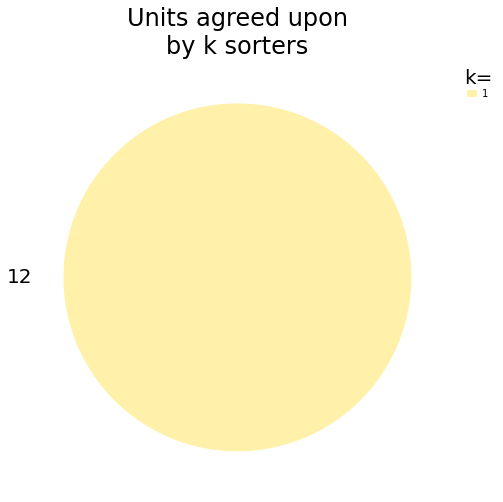

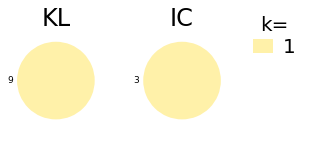

In [34]:
w = sw.plot_multicomp_agreement(mcmp)
w = sw.plot_multicomp_agreement_by_sorter(mcmp)

In [35]:
agreement_sorting = mcmp.get_agreement_sorting(minimum_agreement_count=2)

In [36]:
agreement_sorting.get_unit_ids()

[]

In [37]:
cmp_manual_agr = sc.compare_sorter_to_ground_truth(sorting_KL_phy_curated, agreement_sorting)

NameError: name 'sorting_KL_phy_curated' is not defined

In [40]:
w_agr = sw.plot_agreement_matrix(cmp_manual_agr)

NameError: name 'cmp_manual_agr' is not defined

In [41]:
st.postprocessing.export_to_phy(r_cache, 
                                agreement_sorting, output_folder='phy_AGR',
                                grouping_property='group', verbose=True, recompute_info=True)

Exception: No non-empty units in the sorting result, can't save to phy.

In [ ]:
%%capture --no-display
!phy template-gui phy_AGR/params.py

<a id="export_nwb"></a>
# 7. Save to / load from NWB
[back to index](#index)

TODO delete

Follow https://github.com/catalystneuro/nwb-conversion-tools/blob/master/documentation/conversion_tools_structure.md#step-by-step-operations

and https://github.com/catalystneuro/movshon-lab-to-nwb/blob/main/tutorials/openephys_nwb_conversion_detailed.ipynb

In [9]:
from pynwb import NWBFile, NWBHDF5IO
from nwbwidgets import nwb2widget
from pathlib import Path
import yaml
import pprint

/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/hdmf/spec/namespace.py:206: PendingDeprecationWarning: 
safe_load will be removed, use

  yaml=YAML(typ='safe', pure=True)
  yaml.load(...)

instead
  d = yaml.safe_load(stream)
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ruamel/yaml/main.py:1105: PendingDeprecationWarning: 
load will be removed, use

  yaml=YAML(typ='unsafe', pure=True)
  yaml.load(...)

instead
  return load(stream, SafeLoader, version)
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/hdmf/spec/namespace.py:215: PendingDeprecationWarning: 
safe_load will be removed, use

  yaml=YAML(typ='safe', pure=True)
  yaml.load(...)

instead
  specs = yaml.safe_load(stream)
/mnt/d/spikeinterface/hussaini-to-nwb/tidy_venv/venv/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:282: DeprecationWarning: Widget registration using a string name has been deprecated. Widget registr

In [ ]:
# TODO ...

In [8]:
metadata = {'Ecephys': {'Device': [{'name': 'Axona',
                                    'description': 'Axona DacqUSB acquisition system'}]}}

In [11]:
metadata

{'Ecephys': {'Device': [{'name': 'Axona',
    'description': 'Axona DacqUSB acquisition system'}]}}

In [18]:
se.NwbRecordingExtractor.write_recording(r_cache, 'axona_tutorial_re.nwb', metadata=metadata)

UnsupportedOperation: Cannot read data from file axona_tutorial_re.nwb in mode 'r+'. There are no values.

In [19]:
se.NwbSortingExtractor.write_sorting(sorting_KL, 'axona_tutorial_se.nwb')

/mnt/d/spikeinterface/spikeextractors/spikeextractors/extractors/nwbextractors/nwbextractors.py:1233: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(prop_value, (int, np.integer, float, np.float, str, bool)):
/mnt/d/spikeinterface/spikeextractors/spikeextractors/extractors/nwbextractors/nwbextractors.py:1257: UserWarning: Description for property group not found in property_descriptions. Setting description to 'no description'
  warnings.warn(


In [21]:
recording_nwb = se.NwbRecordingExtractor('axona_tutorial_re.nwb')

UnsupportedOperation: Cannot read data from file axona_tutorial_re.nwb in mode 'r'. There are no values.

In [22]:
sorting_nwb = se.NwbSortingExtractor('axona_tutorial_se.nwb')

/mnt/d/spikeinterface/hussaini-to-nwb/venv/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Exception: No acquisitions found in the .nwb file.

<a id="export_tint"></a>
# 8. Save to / load from TINT
[back to index](#index)

In [ ]:
# TODO ...

In [ ]:
# eof